# VRP Based on ExelSolver Math Model by Gurobi
Parameters:	

* 𝑛 = number of points (1 - depot, 2,…,𝑛 - clients)

* 𝑑_𝑖𝑗 = distance from point 𝑖 to point 𝑗

* 𝐷_𝑖 = demand of client 𝑖

* 𝐶 = capacity of each truck

Variables:	

* 𝑥_𝑖𝑗 = 1 if a truck goes from node 𝑖 to node 𝑗 (binary)

* 𝑓_𝑖𝑗 = number of units in a truck going from node 𝑖 to node 𝑗


$$ \min \sum_{i=1}^{n} \sum_{j=1}^{n} d_{i j} x_{i j} $$
$$ \sum_{j=1}^{n} x_{i j}=1 \quad \forall i=2, \ldots, n $$
$$ \sum_{j=1}^{n} x_{j i}=1 \quad \forall i=2, \ldots, n $$
$$ \sum_{j=1}^{n} f_{j i}-\sum_{j=1}^{n} f_{i j}=D_{i} \quad \forall i=2, \ldots, n $$
$$ 0 \leq f_{i j} \leq C x_{i j} \quad \forall i, j=1, \ldots, n $$
$$ x_{i j} \in\{0,1\} \quad \forall i, j=1, \ldots, n $$

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum

In [113]:
rnd = np.random
rnd.seed(0)

In [114]:
n = 20 # 1 depot and 20 clients
Capacity = 20
xc = rnd.rand(n+1)*200 # [0, ..., n-1]
yc = rnd.rand(n+1)*200

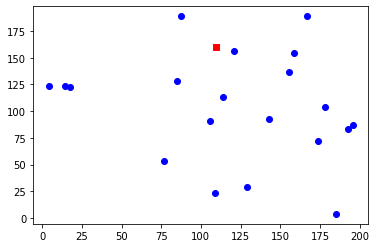

In [115]:
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c='b')

In [116]:
N = [i for i in range(0, n)] # set points
C = N[1:] # set of clients
A = [(i, j) for i in N for j in N if i != j] # set of all arcs

dis = {(i,j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for (i, j) in A} # dictionary for dis
Dmd = {i: rnd.randint(1, 10) for i in C} # dictionary for clients demands


In [117]:
mdl = Model('CVRP') # set model
x = mdl.addVars(A, vtype=GRB.BINARY) # dictionary
f = mdl.addVars(A, vtype=GRB.CONTINUOUS) # dictionary
mdl.modelSense = GRB.MINIMIZE
mdl.setObjective(quicksum(x[(i, j)]*dis[(i, j)] for (i, j) in A))

In [118]:
mdl.addConstrs(quicksum(x[(i, j)] for j in N if j != i) == 1 for i in C) # from i, only 1
mdl.addConstrs(quicksum(x[(j, i)] for j in N if i != j) == 1 for i in C) # come to i, only 1
mdl.addConstrs(quicksum(f[(j, i)] for j in N if j != i) - quicksum(f[(i, j)] for j in N if j != i) == Dmd[i] for i in C)
mdl.addConstrs(0 <= f[(i, j)] for (i,j) in A)
mdl.addConstrs(f[(i, j)] <= Capacity*x[(i, j)] for (i,j) in A)

{(0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 5): <gurobi.Constr *Awaiting Model Update*>,
 (0, 6): <gurobi.Constr *Awaiting Model Update*>,
 (0, 7): <gurobi.Constr *Awaiting Model Update*>,
 (0, 8): <gurobi.Constr *Awaiting Model Update*>,
 (0, 9): <gurobi.Constr *Awaiting Model Update*>,
 (0, 10): <gurobi.Constr *Awaiting Model Update*>,
 (0, 11): <gurobi.Constr *Awaiting Model Update*>,
 (0, 12): <gurobi.Constr *Awaiting Model Update*>,
 (0, 13): <gurobi.Constr *Awaiting Model Update*>,
 (0, 14): <gurobi.Constr *Awaiting Model Update*>,
 (0, 15): <gurobi.Constr *Awaiting Model Update*>,
 (0, 16): <gurobi.Constr *Awaiting Model Update*>,
 (0, 17): <gurobi.Constr *Awaiting Model Update*>,
 (0, 18): <gurobi.Constr *Awaiting Model Update*>,
 (0, 19): <gurobi.Constr *Awaiting Model Update*>,
 (1, 0): <gurobi.Constr *Awaiting Model 

In [119]:
mdl.Params.MIPGap = 0.1
mdl.Params.TimeLimit = 1  # seconds
mdl.optimize()

Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 1
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 817 rows, 760 columns and 2584 nonzeros
Model fingerprint: 0x7cab9564
Variable types: 380 continuous, 380 integer (380 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [3e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+00]
Presolve removed 418 rows and 38 columns
Presolve time: 0.01s
Presolved: 399 rows, 722 columns, 2128 nonzeros
Variable types: 380 continuous, 342 integer (342 binary)
Found heuristic solution: objective 3241.6685892

Root relaxation: objective 1.055222e+03, 530 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1055.22202    0   29 

In [120]:
active_arcs = [a for a in A if x[a].x > 0.99]

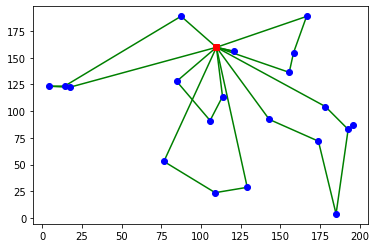

In [121]:
for i, j in active_arcs:
    plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='g', zorder=0)

plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c='b')